<a href="https://colab.research.google.com/github/Ljmarcer/Smote_Variants/blob/main/Smote_Variants_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install smote_variants
!pip install xgboost

In [ ]:
!pip install --upgrade smote_variants


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#  Modelling with Smote and Adaboost
import pandas as pd 
import numpy  as np
import sys, os 
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
import smote_variants as sv
import ipykernel

In [ ]:
# Preparing the workspace
#sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'data' ))
#cwd = os.getcwd()
#df = pd.read_csv('Churn_Modelling.csv')
url ='https://drive.google.com/file/d/1OdYyMFUxhVmxH9xe8qmiif49-fRvnTHq/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.head(19)
df.columns

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


(10000, 14)  rows x columns, Any Null:  False , contains 0 duplicated rows
   index  Exited
0      0    7963
1      1    2037


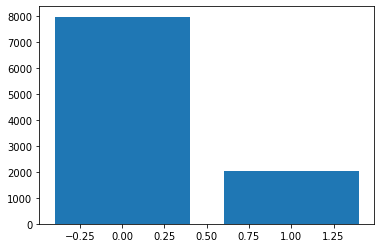

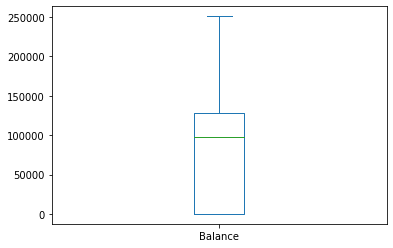

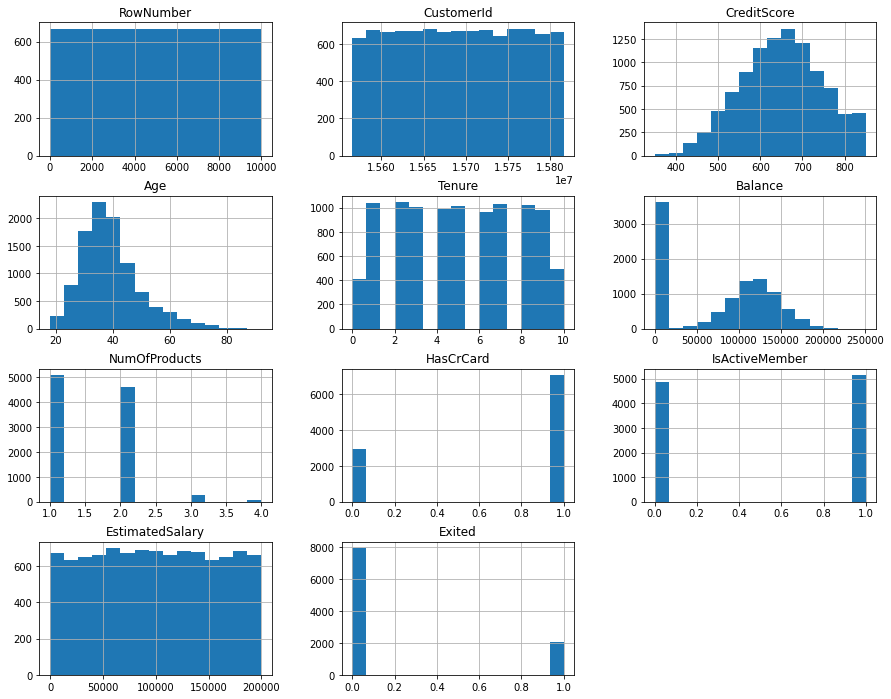

In [ ]:
# Visualizing the data's balance and values
a=df.shape
b=df.isnull().sum().any()
c=df.duplicated().sum()
print (a , " rows x columns, Any Null: ",b, ", contains",c, "duplicated rows")
balance = df['Exited'].value_counts().reset_index()
print(balance)
plt.bar(x= balance["index"], height = balance["Exited"], width =0.8)
plt.show(
)
df.Balance.plot(kind="box")

df.hist(figsize=(15, 12), bins=15);


In [ ]:
# We can clearly detect an imbalance in our dataset, we're gonna start removing sensitive 
# data, this data wouldnt affect our datasets since its better to remove it
#def remove_irrational_values(df:pd.DataFrame) -> pd.DataFrame:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)


# df.head(5)

In [ ]:
# object values are not good for inserting in the models, instead we are going to create a boolean for every string value in the dataset
df = pd.get_dummies(df)
df.head()

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,2,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,3,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,4,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,5,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


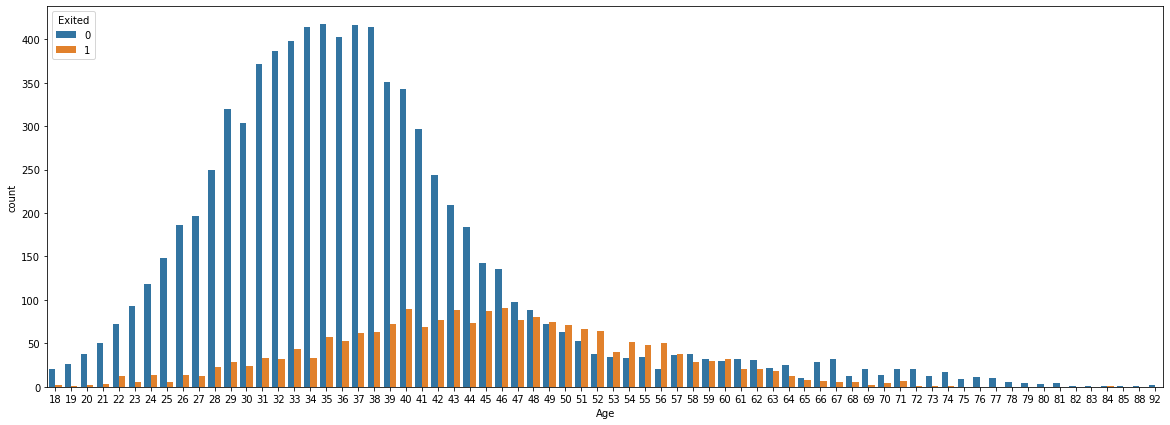

In [ ]:
# Identificamos aqui como la edad va a ser un factor muy importante

plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);


In [ ]:
# df_credit_norm
df.CreditScore.describe()  

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

In [ ]:
# We have to normalize this feature. We can see aswell thtat theres a field that indicates if the user has the companies 'card or not, this could aslso be a Credit Score, so we 
# could  do some feature engeenering and create a column that joins those togheter

def credit_transformer(x, y):
    if x < 584 and y == 0:
        return 0
    if x < 584 and y == 1:
        return 1
    if 584 < x < 718 and y == 0:
        return 2
    if 584 < x < 718 and y == 1:
        return 3
    else:
        return 4


In [ ]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 1, 2, 4, 3, 4, 1, 0, 3]

In [ ]:
#we create a set since we have unique values only

set(customer_value)


{0, 1, 2, 3, 4}

In [ ]:
df.insert(10, "customer_value", customer_value)

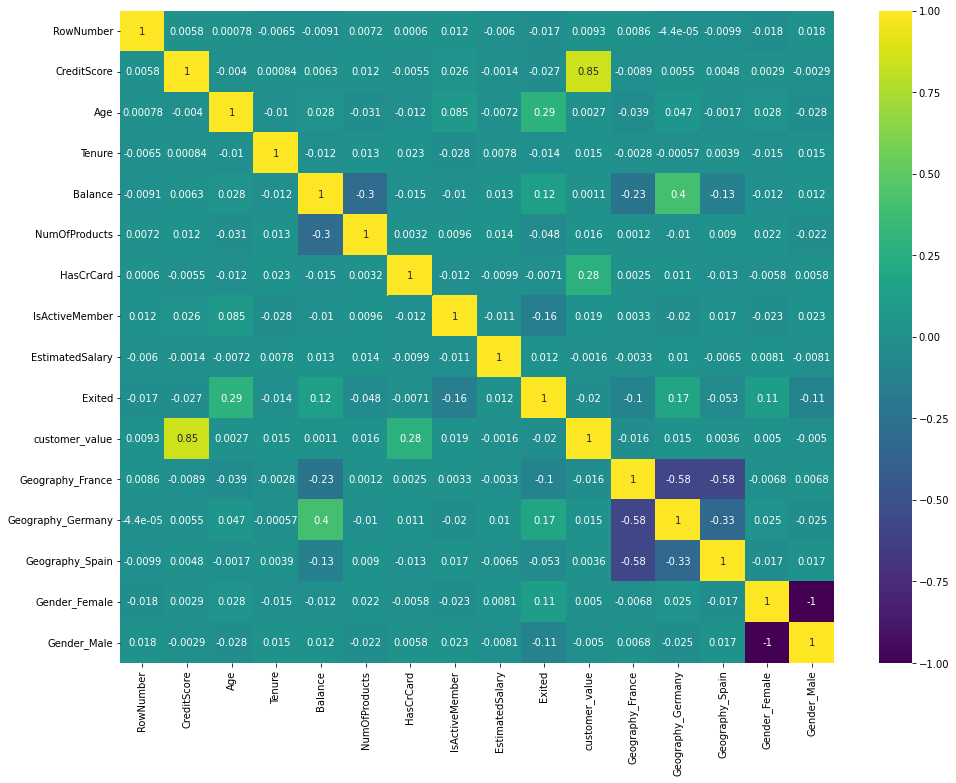

In [ ]:
## for the last step of feautre engineering , lets see the correlation of the values, we spect to see low values, if high values we shuold change the features
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

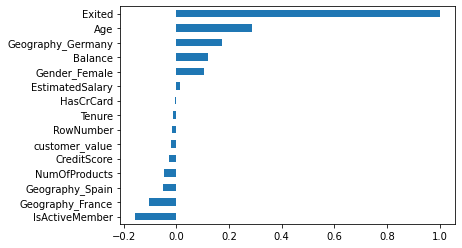

In [ ]:
df.corr()['Exited'][:-1].sort_values().plot.barh();

In [ ]:
df.head(19)

,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,customer_value,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,619,42,2,0.00,1,1,1,101348.88,1,3,1,0,0,1,0
1,2,608,41,1,83807.86,1,0,1,112542.58,0,2,0,0,1,1,0
2,3,502,42,8,159660.80,3,1,0,113931.57,1,1,1,0,0,1,0
3,4,699,39,1,0.00,2,0,0,93826.63,0,2,1,0,0,1,0
4,5,850,43,2,125510.82,1,1,1,79084.10,0,4,0,0,1,1,0
5,6,645,44,8,113755.78,2,1,0,149756.71,1,3,0,0,1,0,1
6,7,822,50,7,0.00,2,1,1,10062.80,0,4,1,0,0,0,1
7,8,376,29,4,115046.74,4,1,0,119346.88,1,1,0,1,0,1,0
8,9,501,44,4,142051.07,2,0,1,74940.50,0,0,1,0,0,0,1
9,10,684,27,2,134603.88,1,1,1,71725.73,0,3,1,0,0,0,1


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline



In [ ]:
 multiclass_smote = sv.get_all_oversamplers_multiclass
 print(type(multiclass_smote))

<class 'function'>


## Data Preparation

In [ ]:
X,y = df.drop(columns = ['Exited'], axis=1 ), df['Exited']


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state = 42)

# Oversampling stage

For the oversampling techniques we are going to use SMOTE and its variations. 



First we get the list of algorithms that support multiclass oversampling, since we have more than one feature, what *smote variants* does is oversampling each pair of features and creates the same amount of rows.

In [ ]:
oversamplers= sv.get_all_oversamplers_multiclass()
list(oversamplers)

[smote_variants._smote_variants.NoSMOTE,
 smote_variants._smote_variants.SMOTE,
 smote_variants._smote_variants.SMOTE_TomekLinks,
 smote_variants._smote_variants.SMOTE_ENN,
 smote_variants._smote_variants.Borderline_SMOTE1,
 smote_variants._smote_variants.Borderline_SMOTE2,
 smote_variants._smote_variants.ADASYN,
 smote_variants._smote_variants.LLE_SMOTE,
 smote_variants._smote_variants.distance_SMOTE,
 smote_variants._smote_variants.SMMO,
 smote_variants._smote_variants.polynom_fit_SMOTE,
 smote_variants._smote_variants.ADOMS,
 smote_variants._smote_variants.Safe_Level_SMOTE,
 smote_variants._smote_variants.MSMOTE,
 smote_variants._smote_variants.DE_oversampling,
 smote_variants._smote_variants.SMOBD,
 smote_variants._smote_variants.MSYN,
 smote_variants._smote_variants.SVM_balance,
 smote_variants._smote_variants.TRIM_SMOTE,
 smote_variants._smote_variants.SMOTE_RSB,
 smote_variants._smote_variants.ProWSyn,
 smote_variants._smote_variants.SL_graph_SMOTE,
 smote_variants._smote_varian


## Smote Distance




[LINK to paper](https://www.researchgate.net/publication/221439119_A_Distance-Based_Over-Sampling_Method_for_Learning_from_Imbalanced_Data_Sets)

This the first imnplementation of Smote, really similar the classic one, SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

in *Smote Distance* the minority class is over-sampled by taking eachminority class sample and adding synthetic examples in theoriginal data. Also, we operate in the ”feature space” ratherthan the ”data space”. However, instead of selecting a near-est neighbor at random among the knearest neighbors (asSMOTE does), we average these neighbors to obtain themean example. In addition, we only consider the positivedata set to ﬁnd the closest instances using the weighted dis-tance.To create the new synthetic positive examples in ourproposed method we do the following: separate positiveand negative examples from the original data set. Findthe nclosest examples to each positive example using theweighted distance. For doing this, we only consider the pos-itive data set. Then, average these nclosest instances to ob-tain the mean example. Take the difference between the mi-nority example and the mean instance. After that, multiplythis difference by a random number between 0and 1, to se-lect a random point. Finally, add the new synthetic positiveinstance to the original data set

In [ ]:
oversampler= sv.MulticlassOversampling(sv.distance_SMOTE(random_state=2))
X_samp_smote, y_samp_smote= oversampler.sample(X_train, y_train)

2022-04-28 18:31:54,294:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-28 18:31:54,299:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-28 18:31:54,304:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 2}")


  ## SMOBD

[LINK to paper](https://www.researchgate.net/publication/254016960_Applying_Oversampling_Technique_Based_on_Data_Density_and_Cost-sensitive_SVM_to_Imbalanced_Learning)

 SMOTE algorithm is a simple and effective over-sampling technique. But SMOTE algorithm ignores data distribution and density information which is important to synthesize minority examples. SMOTE algorithm cannot effectively eliminate the influence of noise either. A novel over-sampling *algorithm-SMOBD* is proposed and shows better performance in experiments

In [ ]:
oversampler_SMOBD= sv.MulticlassOversampling(sv.SMOBD(random_state=2))
X_samp_SMOBD, y_samp_SMOBD= oversampler_SMOBD.sample(X_train, y_train)

2022-04-28 18:31:39,184:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-28 18:31:39,189:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-28 18:31:39,195:INFO:SMOBD: Running sampling via ('SMOBD', "{'proportion': 1.0, 'eta1': 0.5, 't': 1.8, 'min_samples': 5, 'max_eps': 1.0, 'n_jobs': 1, 'random_state': 2}")


## ProWSyn 
 [LINK to paper](https://link.springer.com/chapter/10.1007/978-3-642-37456-2_27)

*Proximity Weighted Synthetic Oversampling Technique (ProWSyn)* generate effective weight values for the minority data
samples based on sample’s proximity information, i.e., distance from
boundary which results in a proper distribution of generated synthetic
samples across the minority data set. Simulation results on some real
world datasets shows the effectiveness of the proposed method showing
improvements in various assessment metrics such as AUC, F-measure,
and G-mean.



In [ ]:
oversampler_ProWSyn= sv.MulticlassOversampling(sv.ProWSyn(random_state = 2))
X_samp_ProWSyn, y_samp_ProWSyn= oversampler_ProWSyn.sample(X_train, y_train)

2022-04-28 18:31:42,075:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-28 18:31:42,086:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-28 18:31:42,096:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 1, 'random_state': 2}")


## G_SMOTE

[LINK to paper](https://ieeexplore.ieee.org/document/6976968)

In [ ]:
oversampler_G_SMOTE= sv.MulticlassOversampling(sv.G_SMOTE(random_state= 2))
X_samp_G_SMOTE, y_samp_G_SMOTE= oversampler_G_SMOTE.sample(X_train, y_train)

2022-04-28 18:31:45,344:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-28 18:31:45,349:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-28 18:31:45,355:INFO:G_SMOTE: Running sampling via ('G_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'method': 'linear', 'n_jobs': 1, 'random_state': 2}")


## polynom_fit_SMOTE

[LINK to paper](https://www.researchgate.net/publication/220933172_New_Oversampling_Approaches_Based_on_Polynomial_Fitting_for_Imbalanced_Data_Sets)

*Poly-fit Smote* is based on oversampling the minority
class using polynomial fitting functions. Four new
approaches were proposed: star topology, bus
topology, polynomial curve topology and mesh
topology. Star and mesh topologies approach had led
to the best performances. 

In [ ]:
oversampler_poly_SMOTE= sv.MulticlassOversampling(sv.polynom_fit_SMOTE(random_state= 2))
X_samp_poly_SMOTE, y_samp_poly_SMOTE= oversampler_poly_SMOTE.sample(X_train, y_train)

2022-04-28 18:31:48,930:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-28 18:31:48,936:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-28 18:31:48,940:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'star', 'random_state': 2}")


# Algorithm predictions

We are going to use 3 different algorithm to produce estimations on what the label is going to be, first we are going to start with the most known Adaboost to go into more complex models like LightGBM and xGboost to see if we can achieve a better performance.

In [ ]:
Accuracy_list =[ []]


## Adaboost 

In [ ]:
Accuracy_AdaBoost = ['Adaboost']

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, make_scorer, auc, accuracy_score, roc_curve
from sklearn.model_selection import cross_val_score

def AdaBoost(X,X_test,Y) -> list:
    # scorer = make_scorer(auc)
    clf_ada = AdaBoostClassifier(random_state=42, n_estimators=10000, learning_rate = 0.001)
    
    #simple one
    clf_ada.fit(X,Y)
    ada_predictions = clf_ada.predict(X_test.values)
    #
    # parameters = {'n_estimators': [10000],
    #              'learning_rate': [0.001]}
    # grid_init = GridSearchCV(clf_ada, parameters, scoring=accuracy_score)
    # grid_fit = grid_init.fit(X, Y)
    # best_clf_ada = grid_fit.best_estimator_
    # best_predictions_ada = best_clf_ada.predict(X_train)
    return ada_predictions
    #return best_predictions_ada

### Predicted values

In [ ]:
y_pred_Ada = AdaBoost(X_train,X_test,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
acc_Ada = accuracy_score(y_test,  y_pred_Ada)
Accuracy_AdaBoost.append(acc_Ada)
f'acc Ada = {acc_Ada}'

'acc Ada = 0.8565'

In [ ]:
y_pred_smote_Ada = AdaBoost(X_samp_smote, X_test, y_samp_smote)


In [ ]:
acc_smote_Ada = accuracy_score(y_test,  y_pred_smote_Ada)
Accuracy_AdaBoost.append(acc_smote_Ada)
f'acc Smote-Ada = {acc_smote_Ada}'

'acc Smote-Ada = 0.8495'

In [ ]:
y_pred_SMOBD_Ada = AdaBoost(X_samp_SMOBD, X_test, y_samp_SMOBD)


In [ ]:
acc_SMOBD_Ada = accuracy_score(y_test,  y_pred_SMOBD_Ada)
Accuracy_AdaBoost.append(acc_SMOBD_Ada)
f'acc SMOBD-Ada = {acc_SMOBD_Ada}'

'acc SMOBD-Ada = 0.827'

In [ ]:
y_pred_ProWSyn_Ada =AdaBoost(X_samp_ProWSyn, X_test, y_samp_ProWSyn)


In [ ]:
acc_ProWSyn_Ada = accuracy_score(y_test,  y_pred_ProWSyn_Ada)
Accuracy_AdaBoost.append(acc_ProWSyn_Ada)
f'acc Ada = {acc_ProWSyn_Ada}'

'acc Ada = 0.8235'

In [ ]:
y_pred_GSMOTE_Ada = AdaBoost(X_samp_G_SMOTE, X_test, y_samp_G_SMOTE)


In [ ]:
acc_GSMOTE_Ada = accuracy_score(y_test,  y_pred_GSMOTE_Ada)
Accuracy_AdaBoost.append(acc_GSMOTE_Ada)
f'acc Ada = {acc_GSMOTE_Ada}'

'acc Ada = 0.827'

In [ ]:
y_pred_poly_Ada =  AdaBoost(X_samp_poly_SMOTE, X_test, y_samp_poly_SMOTE)

In [ ]:
acc_poly_Ada = accuracy_score(y_test,  y_pred_poly_Ada)
Accuracy_AdaBoost.append(acc_poly_Ada)
Accuracy_list.append(Accuracy_AdaBoost)
f'acc Ada = {acc_poly_Ada}'

'acc Ada = 0.8525'


## xGBoost
----
[LINK paper](https://arxiv.org/pdf/1603.02754.pdf)
---
[LINK demo](https://www.themachinelearners.com/xgboost-python/)

XGBoost works as Newton-Raphson in function space unlike gradient boosting that works as gradient descent in function space, a second order Taylor approximation is used in the loss function to make the connection to Newton Raphson method.



In [ ]:
Accuracy_XGBoost = ['XGBoost']

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
def XGBoost(X,X_test,Y) -> list:
    XBC = XGBClassifier(random_state=42, n_estimators=10000, learning_rate = 0.001, objective= 'reg:logistic')
    
    #simple one
    XBC.fit(X,Y)
    XBC_predictions = XBC.predict(X_test.values)
  
    return XBC_predictions

In [ ]:
from scipy.sparse import csr_matrix


In [ ]:
y_pred_XGB = XGBoost(X_train,X_test,y_train)


In [ ]:
acc_XGB = accuracy_score(y_test,  y_pred_XGB)
Accuracy_XGBoost.append(acc_XGB)
f'acc XGBoost = {acc_XGB}'

'acc XGBoost = 0.862'

In [ ]:
y_pred_smote_XGB = XGBoost(X_samp_smote, X_test, y_samp_smote)


In [ ]:
acc_smote_XGB = accuracy_score(y_test,  y_pred_smote_XGB)
Accuracy_XGBoost.append(acc_smote_XGB)
f'acc XGBoost = {acc_smote_XGB}'

'acc XGBoost = 0.862'

In [ ]:
y_pred_SMOBD_XGB = XGBoost(X_samp_SMOBD,X_test,y_samp_SMOBD)


In [ ]:
acc_SMOBD_XGB = accuracy_score(y_test,  y_pred_SMOBD_XGB)
Accuracy_XGBoost.append(acc_SMOBD_XGB)
f'acc XGBoost = {acc_SMOBD_XGB}'

'acc XGBoost = 0.8605'

In [ ]:
y_pred_ProWSyn_XGB = XGBoost(X_samp_ProWSyn,X_test,y_samp_ProWSyn)


In [ ]:
acc_ProWSyn_XGB = accuracy_score(y_test,  y_pred_ProWSyn_XGB)
Accuracy_XGBoost.append(acc_ProWSyn_XGB)
f'acc XGBoost = {acc_ProWSyn_XGB}'

'acc XGBoost = 0.8645'

In [ ]:
y_pred_GSMOTE_XGB = XGBoost(X_samp_G_SMOTE,X_test,y_samp_G_SMOTE)


In [ ]:
acc_GSMOTE_XGB = accuracy_score(y_test,  y_pred_GSMOTE_XGB)
Accuracy_XGBoost.append(acc_GSMOTE_XGB)
f'acc XGBoost = {acc_GSMOTE_XGB}'

'acc XGBoost = 0.8635'

In [ ]:
y_pred_poly_XGB = XGBoost(X_samp_poly_SMOTE,X_test,y_samp_poly_SMOTE)


In [ ]:
acc_poly_XGB = accuracy_score(y_test,  y_pred_poly_XGB)
Accuracy_XGBoost.append(acc_poly_XGB)
Accuracy_list.append(Accuracy_XGBoost)
f'acc XGBoost = {acc_poly_XGB}'

'acc XGBoost = 0.864'

In [ ]:
Accuracy_list

[[],
 ['Adaboost', 0.8565, 0.8495, 0.827, 0.8235, 0.827, 0.8525],
 ['XGBoost', 0.862, 0.862, 0.8605, 0.8645, 0.8635, 0.864]]

##LightGBM
----

[LINK paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
---
[LINK demo](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.


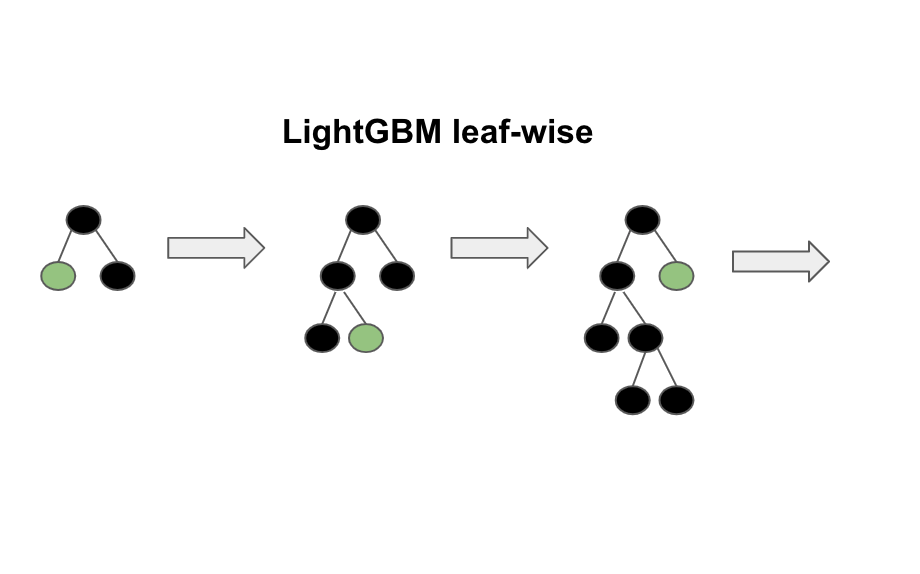



In [ ]:
Accuracy_lgb = ['LightGBM']

In [ ]:
from numpy.core.multiarray import result_type
from seaborn.rcmod import reset_defaults
import lightgbm as lgb  
import numpy as np
def lightgbm(X_train,X_test,y_train,y_test) -> list:
    lgb_train = lgb.Dataset(X_train, y_train)  
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  

    params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': {'binary_logloss', 'auc'},  # Pérdida logarítmica binaria
    'num_leaves': 5,  
    'max_depth': 6,  
    'min_data_in_leaf': 450,  
    'learning_rate': 0.1,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.95,  
    'bagging_freq': 5,  
    'lambda_l1': 1,    
    'lambda_l2': 0.001,  # Cuanto menor es la regularidad l2, mayor es  
    'min_gain_to_split': 0.2,  
    'verbose': 5,  
    'is_unbalance': False  
      }

    gbm = lgb.train(params,  
                lgb_train,  
                num_boost_round=10000,  
                valid_sets=lgb_eval,  
                early_stopping_rounds=500)  
    #simple one
  

    LGBM_predictions = gbm.predict(X_test.values, num_iteration=gbm.best_iteration) 

    return LGBM_predictions

In [ ]:
y_pred_lgb = lightgbm(X_train,X_test,y_train,y_test)

y_pred_lgb = np.around(y_pred_lgb)
acc_lgb = accuracy_score(y_test, y_pred_lgb)
Accuracy_lgb.append(acc_lgb)
f'acc lgb = {acc_lgb}'

[1]	valid_0's auc: 0.749979	valid_0's binary_logloss: 0.478211
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.799216	valid_0's binary_logloss: 0.47014
[3]	valid_0's auc: 0.796267	valid_0's binary_logloss: 0.463795
[4]	valid_0's auc: 0.810087	valid_0's binary_logloss: 0.451331
[5]	valid_0's auc: 0.814051	valid_0's binary_logloss: 0.441704
[6]	valid_0's auc: 0.812988	valid_0's binary_logloss: 0.434096
[7]	valid_0's auc: 0.812612	valid_0's binary_logloss: 0.42778
[8]	valid_0's auc: 0.812766	valid_0's binary_logloss: 0.421813
[9]	valid_0's auc: 0.811208	valid_0's binary_logloss: 0.417539
[10]	valid_0's auc: 0.811445	valid_0's binary_logloss: 0.413181
[11]	valid_0's auc: 0.81393	valid_0's binary_logloss: 0.40921
[12]	valid_0's auc: 0.815872	valid_0's binary_logloss: 0.405727
[13]	valid_0's auc: 0.815886	valid_0's binary_logloss: 0.403031
[14]	valid_0's auc: 0.817428	valid_0's binary_logloss: 0.400253
[15]	valid_0's auc: 0.817013	valid_0's binary_logloss:

'acc lgb = 0.847'

In [ ]:
y_pred_lgb_smote = lightgbm(X_samp_smote,X_test,y_samp_smote,y_test)
y_pred_lgb_smote =  np.around(y_pred_lgb_smote)
acc_smote_lgb = accuracy_score(y_test, y_pred_lgb_smote)
Accuracy_lgb.append(acc_smote_lgb)
f'acc lgb = {acc_smote_lgb}'

[1]	valid_0's auc: 0.745469	valid_0's binary_logloss: 0.657276
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.762046	valid_0's binary_logloss: 0.626783
[3]	valid_0's auc: 0.76451	valid_0's binary_logloss: 0.599481
[4]	valid_0's auc: 0.763397	valid_0's binary_logloss: 0.577796
[5]	valid_0's auc: 0.779265	valid_0's binary_logloss: 0.557889
[6]	valid_0's auc: 0.794519	valid_0's binary_logloss: 0.537423
[7]	valid_0's auc: 0.796061	valid_0's binary_logloss: 0.518786
[8]	valid_0's auc: 0.79599	valid_0's binary_logloss: 0.503335
[9]	valid_0's auc: 0.797338	valid_0's binary_logloss: 0.490116
[10]	valid_0's auc: 0.796049	valid_0's binary_logloss: 0.478864
[11]	valid_0's auc: 0.798679	valid_0's binary_logloss: 0.468614
[12]	valid_0's auc: 0.800541	valid_0's binary_logloss: 0.461421
[13]	valid_0's auc: 0.801462	valid_0's binary_logloss: 0.453107
[14]	valid_0's auc: 0.823094	valid_0's binary_logloss: 0.440326
[15]	valid_0's auc: 0.825644	valid_0's binary_loglos

'acc lgb = 0.8635'

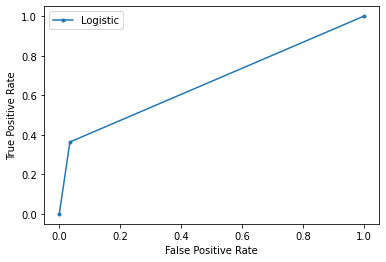

In [ ]:

lr_auc = roc_auc_score(y_test, np.around(y_pred_lgb))
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_lgb)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
y_pred_SMOBD_lgb = lightgbm(X_samp_SMOBD,X_test,y_samp_SMOBD,y_test)
y_pred_SMOBD_lgb =  np.around(y_pred_SMOBD_lgb)
acc_SMOBD_lgb = accuracy_score(y_test, y_pred_SMOBD_lgb)
Accuracy_lgb.append(acc_SMOBD_lgb)
f'acc lgb = {acc_SMOBD_lgb}'

[1]	valid_0's auc: 0.7451	valid_0's binary_logloss: 0.662662
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.749315	valid_0's binary_logloss: 0.641811
[3]	valid_0's auc: 0.733874	valid_0's binary_logloss: 0.623916
[4]	valid_0's auc: 0.772737	valid_0's binary_logloss: 0.602689
[5]	valid_0's auc: 0.784492	valid_0's binary_logloss: 0.58677
[6]	valid_0's auc: 0.78598	valid_0's binary_logloss: 0.569448
[7]	valid_0's auc: 0.791854	valid_0's binary_logloss: 0.558084
[8]	valid_0's auc: 0.795839	valid_0's binary_logloss: 0.545218
[9]	valid_0's auc: 0.820096	valid_0's binary_logloss: 0.525406
[10]	valid_0's auc: 0.830018	valid_0's binary_logloss: 0.50873
[11]	valid_0's auc: 0.830894	valid_0's binary_logloss: 0.498352
[12]	valid_0's auc: 0.834869	valid_0's binary_logloss: 0.484792
[13]	valid_0's auc: 0.839225	valid_0's binary_logloss: 0.472862
[14]	valid_0's auc: 0.841548	valid_0's binary_logloss: 0.464232
[15]	valid_0's auc: 0.844173	valid_0's binary_logloss: 

'acc lgb = 0.859'

In [ ]:
y_pred_ProWSyn_lgb = lightgbm(X_samp_ProWSyn,X_test,y_samp_ProWSyn,y_test)
y_pred_ProWSyn_lgb =  np.around(y_pred_ProWSyn_lgb)
acc_ProWSyn_lgb  = accuracy_score(y_test, y_pred_ProWSyn_lgb)
Accuracy_lgb.append(acc_ProWSyn_lgb)
f'acc lgb = {acc_ProWSyn_lgb}'

[1]	valid_0's auc: 0.718704	valid_0's binary_logloss: 0.668286
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.727258	valid_0's binary_logloss: 0.646364
[3]	valid_0's auc: 0.798777	valid_0's binary_logloss: 0.618048
[4]	valid_0's auc: 0.794218	valid_0's binary_logloss: 0.602196
[5]	valid_0's auc: 0.80202	valid_0's binary_logloss: 0.58693
[6]	valid_0's auc: 0.819635	valid_0's binary_logloss: 0.562815
[7]	valid_0's auc: 0.824548	valid_0's binary_logloss: 0.549172
[8]	valid_0's auc: 0.830603	valid_0's binary_logloss: 0.530379
[9]	valid_0's auc: 0.834357	valid_0's binary_logloss: 0.515411
[10]	valid_0's auc: 0.838216	valid_0's binary_logloss: 0.503468
[11]	valid_0's auc: 0.841394	valid_0's binary_logloss: 0.491811
[12]	valid_0's auc: 0.839679	valid_0's binary_logloss: 0.480106
[13]	valid_0's auc: 0.841555	valid_0's binary_logloss: 0.468334
[14]	valid_0's auc: 0.842595	valid_0's binary_logloss: 0.459187
[15]	valid_0's auc: 0.845138	valid_0's binary_loglos

'acc lgb = 0.8635'

In [ ]:
y_pred_GSMOTE_lgb = lightgbm(X_samp_G_SMOTE,X_test,y_samp_G_SMOTE,y_test)
y_pred_GSMOTE_lgb =  np.around(y_pred_GSMOTE_lgb)
acc_GSMOTE_lgb= accuracy_score(y_test, y_pred_GSMOTE_lgb)
Accuracy_lgb.append(acc_GSMOTE_lgb)
f'acc lgb = {acc_GSMOTE_lgb}'

[1]	valid_0's auc: 0.751775	valid_0's binary_logloss: 0.660518
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.753816	valid_0's binary_logloss: 0.639352
[3]	valid_0's auc: 0.753816	valid_0's binary_logloss: 0.621511
[4]	valid_0's auc: 0.777081	valid_0's binary_logloss: 0.601408
[5]	valid_0's auc: 0.782757	valid_0's binary_logloss: 0.584131
[6]	valid_0's auc: 0.791674	valid_0's binary_logloss: 0.567817
[7]	valid_0's auc: 0.794719	valid_0's binary_logloss: 0.552938
[8]	valid_0's auc: 0.815898	valid_0's binary_logloss: 0.535795
[9]	valid_0's auc: 0.816541	valid_0's binary_logloss: 0.526944
[10]	valid_0's auc: 0.828344	valid_0's binary_logloss: 0.509436
[11]	valid_0's auc: 0.836954	valid_0's binary_logloss: 0.494138
[12]	valid_0's auc: 0.838129	valid_0's binary_logloss: 0.484886
[13]	valid_0's auc: 0.842085	valid_0's binary_logloss: 0.472675
[14]	valid_0's auc: 0.840137	valid_0's binary_logloss: 0.464677
[15]	valid_0's auc: 0.843944	valid_0's binary_logl

'acc lgb = 0.8595'

In [ ]:
y_pred_poly_lgb = lightgbm(X_samp_poly_SMOTE,X_test,y_samp_poly_SMOTE,y_test)
y_pred_poly_lgb =  np.around(y_pred_poly_lgb)
acc_poly_lgb= accuracy_score(y_test, y_pred_poly_lgb)
Accuracy_lgb.append(acc_poly_lgb)
Accuracy_list.append(Accuracy_lgb)
f'acc lgb = {acc_poly_lgb}'

[1]	valid_0's auc: 0.660529	valid_0's binary_logloss: 0.659455
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.741536	valid_0's binary_logloss: 0.626396
[3]	valid_0's auc: 0.738905	valid_0's binary_logloss: 0.599208
[4]	valid_0's auc: 0.769513	valid_0's binary_logloss: 0.571886
[5]	valid_0's auc: 0.77127	valid_0's binary_logloss: 0.549215
[6]	valid_0's auc: 0.778373	valid_0's binary_logloss: 0.529886
[7]	valid_0's auc: 0.785919	valid_0's binary_logloss: 0.513352
[8]	valid_0's auc: 0.79285	valid_0's binary_logloss: 0.498566
[9]	valid_0's auc: 0.794834	valid_0's binary_logloss: 0.48629
[10]	valid_0's auc: 0.793087	valid_0's binary_logloss: 0.475594
[11]	valid_0's auc: 0.794369	valid_0's binary_logloss: 0.466016
[12]	valid_0's auc: 0.793034	valid_0's binary_logloss: 0.458234
[13]	valid_0's auc: 0.796372	valid_0's binary_logloss: 0.451273
[14]	valid_0's auc: 0.795129	valid_0's binary_logloss: 0.445046
[15]	valid_0's auc: 0.79485	valid_0's binary_logloss:

'acc lgb = 0.8615'

In [ ]:
Accuracy_list

[[],
 ['Adaboost', 0.8565, 0.8495, 0.827, 0.8235, 0.827, 0.8525],
 ['XGBoost', 0.862, 0.862, 0.8605, 0.8645, 0.8635, 0.864],
 ['LightGBM', 0.847, 0.8635, 0.859, 0.8635, 0.8595, 0.8615]]

## Metrics Table

In [ ]:
df = pd.DataFrame(Accuracy_list, columns= ['Alg','No-Smote', 'Smote', 'SMOBD', 'ProWSyn', 'GSMOTE', 'Polyfit'] )
df = df.iloc[1: , :]
df.head()

,Alg,No-Smote,Smote,SMOBD,ProWSyn,GSMOTE,Polyfit
1,Adaboost,0.8565,0.8495,0.8270,0.8235,0.8270,0.8525
2,XGBoost,0.8620,0.8620,0.8605,0.8645,0.8635,0.8640
3,LightGBM,0.8470,0.8635,0.8590,0.8635,0.8595,0.8615


## Smote selector  (Prototype)

In [ ]:
from numpy.core.multiarray import result_type
from seaborn.rcmod import reset_defaults
import lightgbm as lgb  
import numpy as np
def compute(X,y):
 # Train_Test_split
    X_train, X_test, y_train, y_test = train_test_split(X_samp_smote,y_samp_smote,test_size= 0.2, random_state = 42)
  # Create model and train it 
    lgb_train = lgb.Dataset(X_train, y_train)  
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  

    params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': {'binary_logloss', 'auc'},  # Pérdida logarítmica binaria
    'num_leaves': 5,  
    'max_depth': 6,  
    'min_data_in_leaf': 450,  
    'learning_rate': 0.1,  
    'feature_fraction': 0.9,  
    'bagging_fraction': 0.95,  
    'bagging_freq': 5,  
    'lambda_l1': 1,    
    'lambda_l2': 0.001,  # Cuanto menor es la regularidad l2, mayor es  
    'min_gain_to_split': 0.2,  
    'verbose': 5,  
    'is_unbalance': False  
      }

    gbm = lgb.train(params,  
                lgb_train,  
                num_boost_round=10000,  
                valid_sets=lgb_eval,  
                early_stopping_rounds=500)  
    
    # predict and evaluate acc

    LGBM_predictions = gbm.predict(X_test, num_iteration=gbm.best_iteration) 
    acc_lgb = accuracy_score(y_test,  np.around(LGBM_predictions))
    return acc_lgb

In [ ]:
oversamplers= sv.get_all_oversamplers_multiclass()
oversamplers = list(oversamplers)
acc_listed = []
used_algs = []
del oversamplers[0]
for alg in oversamplers:
  #accuracy, i = compute(alg,X,y)
  #acc_listed.append()
  try:
    oversampler= sv.MulticlassOversampling(alg(random_state=42))
    X_samp_smote, y_samp_smote= oversampler.sample(X, y)
    accuracy = compute(alg,X_samp_smote,y_samp_smote)
    used_algs.append(alg)
    acc_listed.append(accuracy)
  except:
    pass
  #print(f'{alg} with a accuracy: {accuracy}')

2022-04-12 14:58:32,922:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-12 14:58:32,935:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-12 14:58:32,944:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 42}")
2022-04-12 14:58:33,043:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2022-04-12 14:58:33,059:INFO:MulticlassOversampling: Sampling minority class with label: 1
2022-04-12 14:58:33,073:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 42}")
2022-04-12 14:58:33,076:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': RandomState(MT19937) at 0x7F05459B0D10}")
2022-04-12 14:58:33,244:INFO:TomekLinkRemoval: Running noise removal via TomekLinkRemoval
2

In [ ]:
print(acc_listed)

In [ ]:
print(used_algs)